# Compare methods notebook

In [1]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem

In [2]:
class Result:
	def __init__(self, result_dict) -> None:
		for key in result_dict:
			setattr(self, key, result_dict[key])
		if self.method == "ptmcmc":
			burn_in_idx = self.algo_specific_info["burn_in_idx"]
			n_chains = self.algo_specific_info["n_chains"]
			print(f"{burn_in_idx}, \t{n_chains}")
			self.n_fun_calls = burn_in_idx*n_chains

class MethodResults:
	def __init__(self, method) -> None:
		self.all_runs = []
		self.method = method
		if method == "pmc":
			self.abbr = "PMC"
			self.label = "Preconditioned Monte Carlo"
		elif method == "smc":
			self.abbr = "SMC"
			self.label = "Sequential Monte Carlo"
		elif method == "ptmcmc":
			self.abbr = "PT-MCMC"
			self.label = "Parallel Tempering MCMC"
	
	def add_result(self, result_obj):
		self.all_runs.append(result_obj)

	def get_fun_calls(self) -> np.array:
		all_calls = [x.n_fun_calls for x in self.all_runs]
		return np.array(all_calls)
	
	def get_llhs(self) -> np.array:
		all_llhs = [x.posterior_llh for x in self.all_runs]
		return np.array(all_llhs)

In [3]:
prob_name = "Michaelis_Menten"
methods = ["smc", "pmc", "ptmcmc"]

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		print(fname)
		with open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
		
		

results/Michaelis_Menten/smc/Michaelis_Menten_smc_0seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_1seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_2seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_3seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_4seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_5seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_6seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_7seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_8seed.pkl
results/Michaelis_Menten/smc/Michaelis_Menten_smc_9seed.pkl
results/Michaelis_Menten/pmc/Michaelis_Menten_pmc_0seed.pkl
results/Michaelis_Menten/pmc/Michaelis_Menten_pmc_1seed.pkl
results/Michaelis_Menten/pmc/Michaelis_Menten_pmc_2seed.pkl
results/Michaelis_Menten/pmc/Michaelis_Menten_pmc_3seed.pkl
results/Michaelis_Menten/pmc/Michaelis_Menten_pmc_4seed.pkl
results/Michaelis_Menten/pmc/Michaelis_Menten_pmc_5seed.pkl
results/Michaelis_Menten/pmc/Michaelis_M

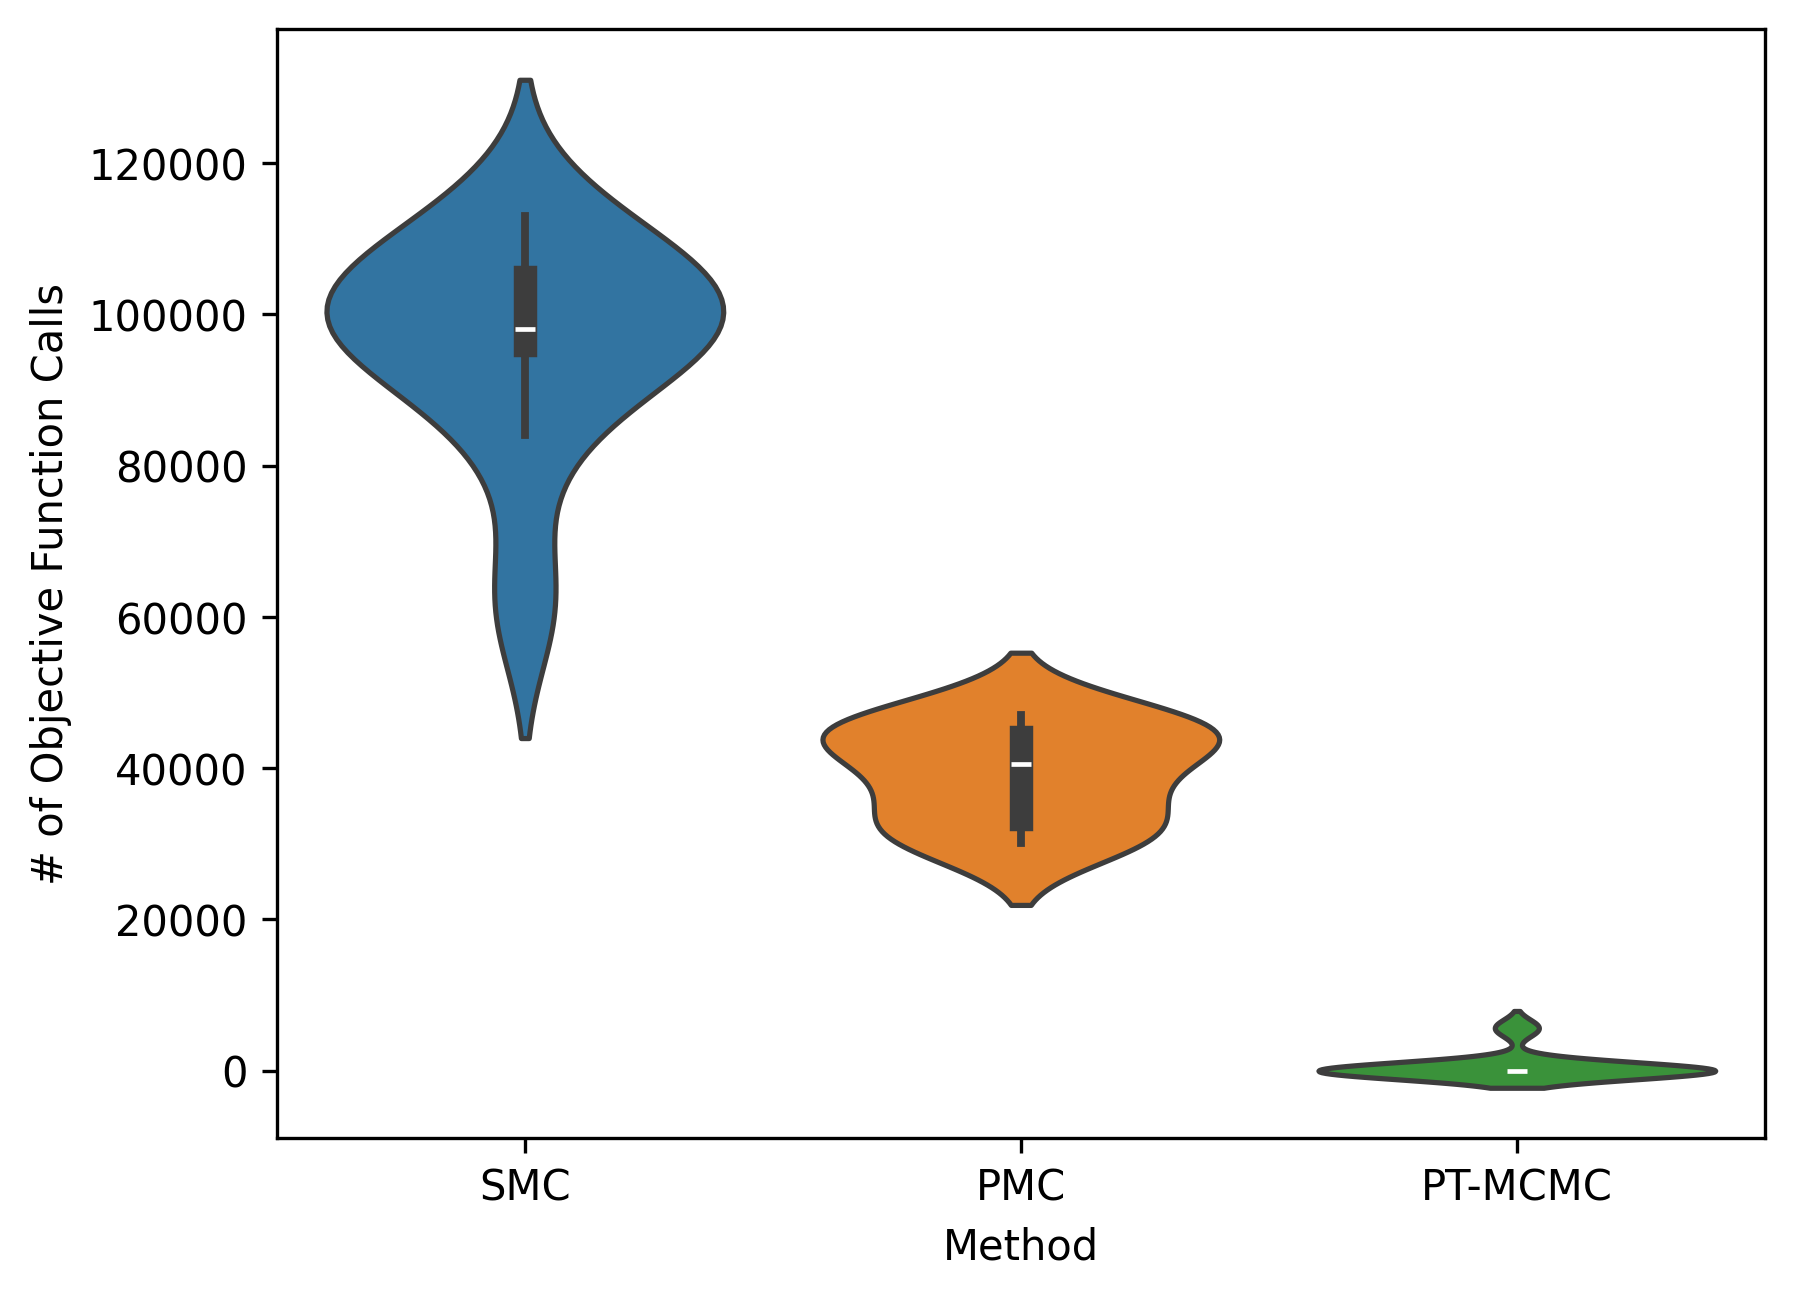

In [4]:
plt.figure(dpi=300)
calls = np.array([x.get_fun_calls() for x in grouped_results])
call_df = pd.DataFrame(columns=methods, data=calls.T)
sns.violinplot(call_df)
plt.xticks([0,1,2], [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("# of Objective Function Calls");

(3, 10, 1000)
(3, 10)
[7, 9, 9]


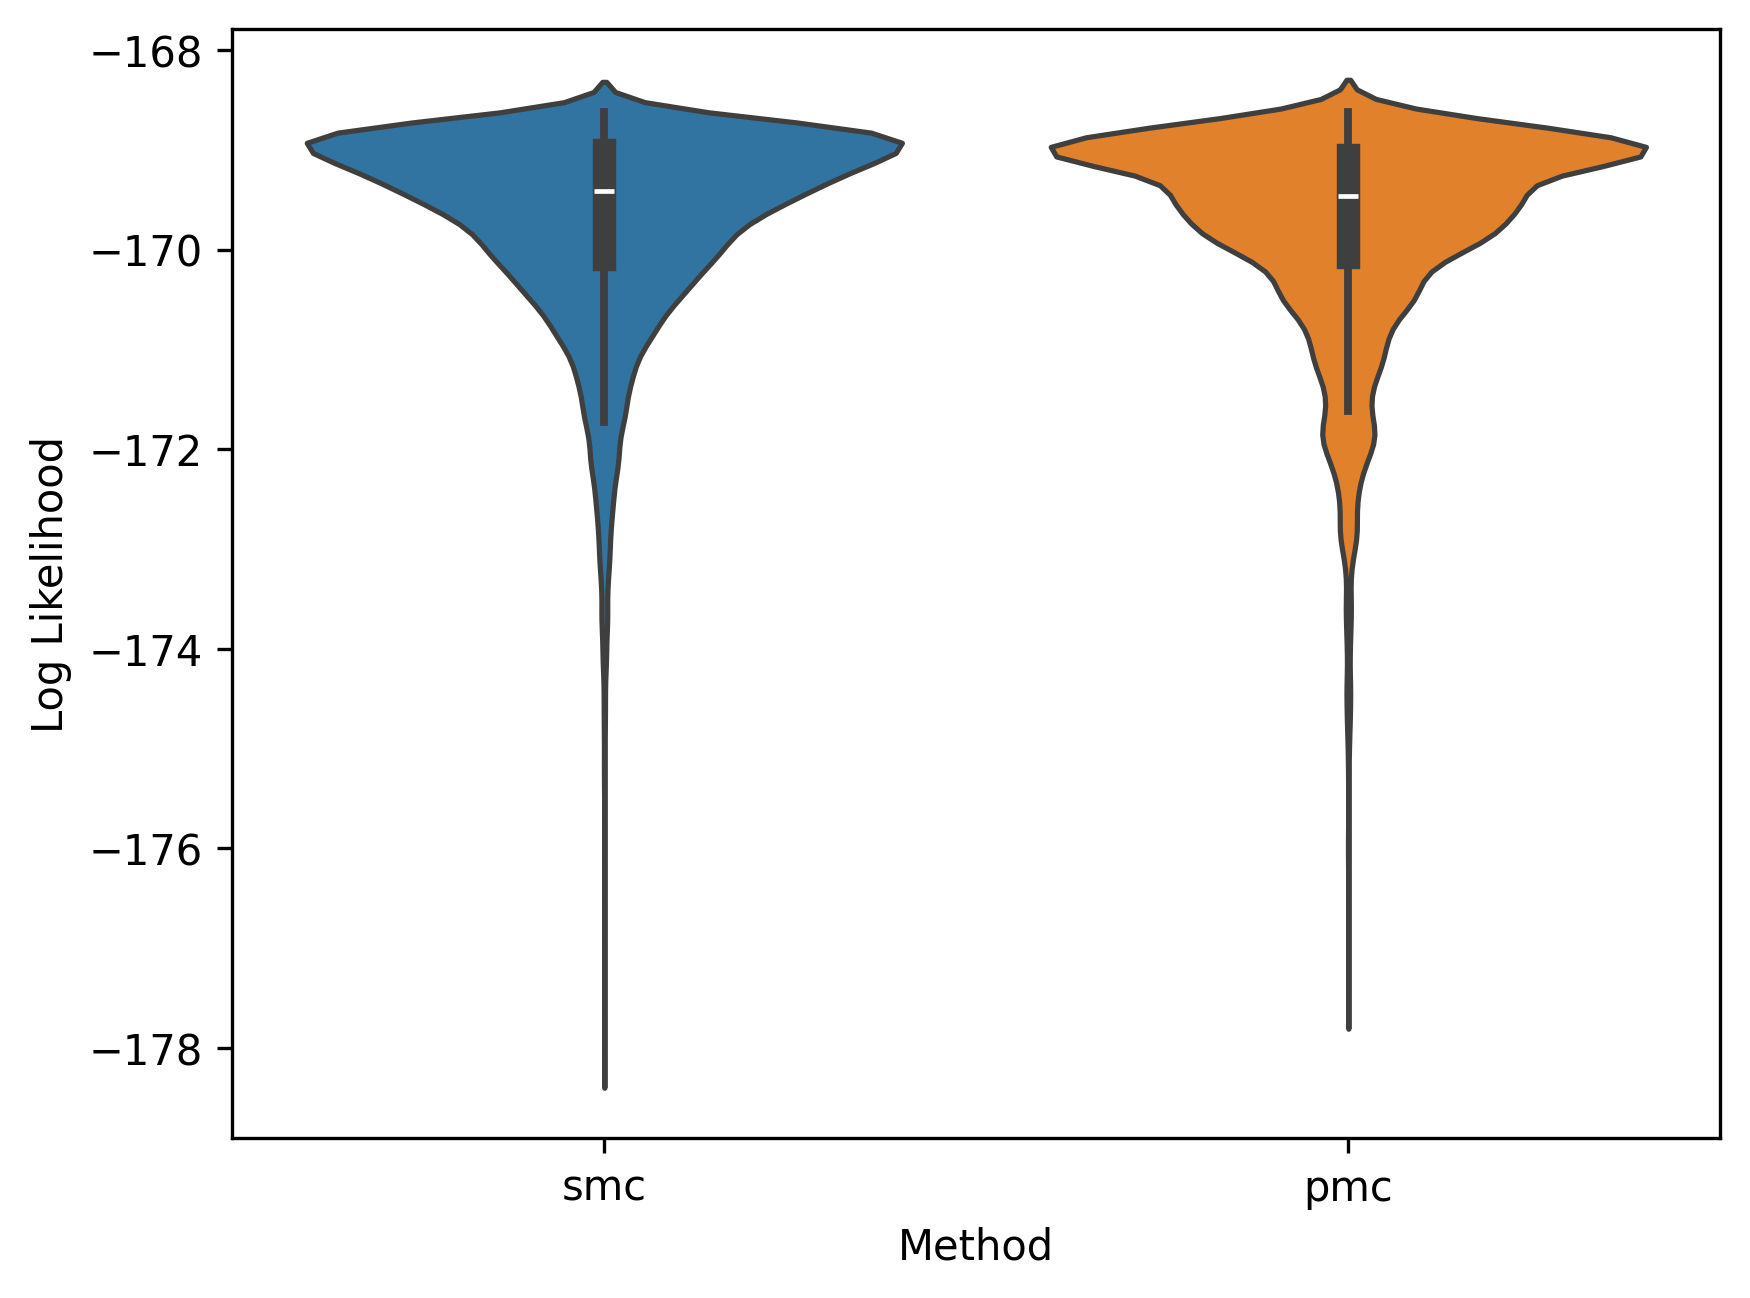

In [17]:
plt.figure(dpi=300)
llhs = np.array([x.get_llhs() for x in grouped_results])
best_runs = [np.argmax(np.max(x, axis=1)) for x in llhs]
llhs = np.reshape(llhs, (llhs.shape[0], llhs.shape[1]*llhs.shape[2]))
llhs_df = pd.DataFrame(columns=methods[:-1], data=llhs.T[:, :-1])
sns.violinplot(llhs_df)
#plt.xticks([0,1,2], [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("Log Likelihood");


In [ ]:
best_smc = grouped_results[0, ]